In [22]:
%pip install yfinance


Note: you may need to restart the kernel to use updated packages.


In [23]:
import yfinance as yf
import pandas as pd

nifty = yf.download(
    "^NSEI",
    start="2015-01-01",
    end="2025-01-01",
    interval="1d"
)

nifty.reset_index(inplace=True)
nifty.head()


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
0,2015-01-02,8395.450195,8410.599609,8288.700195,8288.700195,101900
1,2015-01-05,8378.400391,8445.599609,8363.900391,8407.950195,118200
2,2015-01-06,8127.350098,8327.849609,8111.350098,8325.299805,172800
3,2015-01-07,8102.100098,8151.200195,8065.450195,8118.649902,164100
4,2015-01-08,8234.599609,8243.500000,8167.299805,8191.399902,143800


In [24]:
nifty.to_csv("../data/raw/nifty_spot_daily.csv", index=False)


In [27]:
# Example: load cleaned daily data
df = pd.read_csv("../data/raw/nifty_spot_daily.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

df.head()


,Close,High,Low,Open,Volume
Date,,,,,
NaT,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
2015-01-02,8395.4501953125,8410.599609375,8288.7001953125,8288.7001953125,101900
2015-01-05,8378.400390625,8445.599609375,8363.900390625,8407.9501953125,118200
2015-01-06,8127.35009765625,8327.849609375,8111.35009765625,8325.2998046875,172800
2015-01-07,8102.10009765625,8151.2001953125,8065.4501953125,8118.64990234375,164100


In [28]:
df.dtypes


Close     object
High      object
Low       object
Open      object
Volume    object
dtype: object

In [29]:


price_cols = ["Open", "High", "Low", "Close", "Volume"]

for col in price_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [30]:
df.dropna(inplace=True)


In [31]:
df.dtypes


Close     float64
High      float64
Low       float64
Open      float64
Volume    float64
dtype: object

In [32]:
df["SMA_20"] = df["Close"].rolling(20).mean()
df["SMA_50"] = df["Close"].rolling(50).mean()
df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()


In [33]:
delta = df["Close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df["RSI_14"] = 100 - (100 / (1 + rs))


In [34]:
df["signal"] = 0

df.loc[
    (df["SMA_20"] > df["SMA_50"]) & (df["RSI_14"] > 50),
    "signal"
] = 1

df.loc[
    (df["SMA_20"] < df["SMA_50"]) & (df["RSI_14"] < 50),
    "signal"
] = -1


In [35]:
df["position"] = df["signal"].shift(1)


In [36]:
df.dropna(inplace=True)


In [37]:
df["market_return"] = df["Close"].pct_change()
df["strategy_return"] = df["position"] * df["market_return"]


In [38]:
df["cum_market"] = (1 + df["market_return"]).cumprod()
df["cum_strategy"] = (1 + df["strategy_return"]).cumprod()


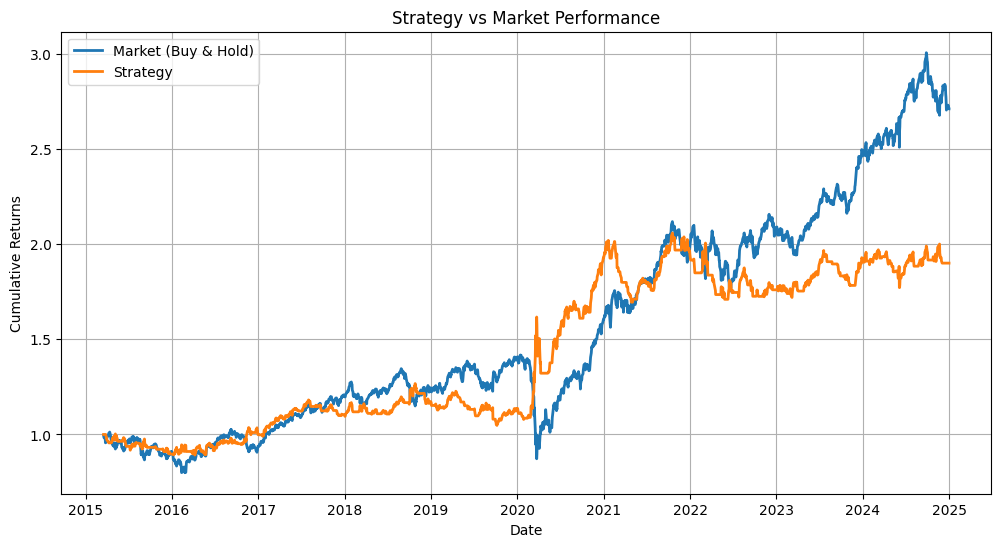

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df.index, df["cum_market"], label="Market (Buy & Hold)", linewidth=2)
plt.plot(df.index, df["cum_strategy"], label="Strategy", linewidth=2)
plt.legend()
plt.title("Strategy vs Market Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.grid(True)
plt.show()
